In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("QVI_data.csv")

### Select control stores
The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.<br>
<br>
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :<br>
<br>
• Monthly overall sales revenue<br>
• Monthly number of customers<br>
• Monthly number of transactions per customer<br>
<br>
Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period


In [2]:
# Convert DATE column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Calculate these measures over time for each store
# Create a month ID
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Define the measure calculations
measureOverTime = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=pd.NamedAgg(column='TOT_SALES', aggfunc='sum'),
    nCustomers=pd.NamedAgg(column='LYLTY_CARD_NBR', aggfunc='nunique'),
    nTxn=pd.NamedAgg(column='TXN_ID', aggfunc='nunique'),
    nChips=pd.NamedAgg(column='PROD_QTY', aggfunc='sum'),
    nUnits=pd.NamedAgg(column='PROD_QTY', aggfunc='sum')
).reset_index()

# Calculate derived measures
measureOverTime['nTxnPerCust'] = measureOverTime['nTxn'] / measureOverTime['nCustomers']
measureOverTime['nChipsPerTxn'] = measureOverTime['nChips'] / measureOverTime['nTxn']
measureOverTime['avgPricePerUnit'] = measureOverTime['totSales'] / measureOverTime['nUnits']

# Filter to the pre-trial period and stores with full observation periods
storesWithFullObs = measureOverTime[measureOverTime.groupby('STORE_NBR')['YEARMONTH'].transform('nunique') == 12]['STORE_NBR'].unique()
preTrialMeasures = measureOverTime[(measureOverTime['YEARMONTH'] < 201902) & (measureOverTime['STORE_NBR'].isin(storesWithFullObs))]


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We
can calculate how correlated the performance of each store is to the trial store.<br>
Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [3]:
def calculate_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns=["Store1", "Store2", "corr_measure"])
    store_numbers = input_table["STORE_NBR"].unique()
    
    for i in store_numbers:
        measure_store_comparison = input_table[input_table["STORE_NBR"] == store_comparison][metric_col]
        measure_i = input_table[input_table["STORE_NBR"] == i][metric_col]
        
        corr_measure = np.corrcoef(measure_store_comparison, measure_i)[0, 1]

        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison],
            "Store2": [i],
            "corr_measure": [corr_measure]
        })
        
        calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)
    
    return calc_corr_table


Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.<br>
Let’s write a function for this.

In [4]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=["Store1", "Store2", "YEARMONTH", "measure"])
    store_numbers = input_table["STORE_NBR"].unique()
    
    for i in store_numbers:
        year_month_comparison = input_table[input_table["STORE_NBR"] == store_comparison]["YEARMONTH"]
        measure_store_comparison = input_table[input_table["STORE_NBR"] == store_comparison][metric_col]
        measure_i = input_table[input_table["STORE_NBR"] == i][metric_col]
        
        # Check if the lengths of arrays match
        if len(measure_store_comparison) != len(measure_i):
            continue  # Skip if lengths do not match
        
        measure_difference = abs(measure_store_comparison.values - measure_i.values)
        
        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison] * len(measure_difference),
            "Store2": [i] * len(measure_difference),
            "YEARMONTH": year_month_comparison.values,
            "measure": measure_difference
        })
        
        calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)
    
    # Standardize the magnitude distance to range from 0 to 1
    min_max_dist = calc_dist_table.groupby(["Store1", "YEARMONTH"])["measure"].agg(
        minDist="min",
        maxDist="max"
    ).reset_index()

    dist_table = pd.merge(calc_dist_table, min_max_dist, on=["Store1", "YEARMONTH"])
    dist_table["mag_measure"] = 1 - (dist_table["measure"] - dist_table["minDist"]) / (dist_table["maxDist"] - dist_table["minDist"])
    
    final_dist_table = dist_table.groupby(["Store1", "Store2"])["mag_measure"].mean().reset_index()
    
    return final_dist_table


Now let’s use the functions to find the control stores! We’ll select control stores based on how similar
monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will
need to use our functions to get four scores, two for each of total sales and total customers.

In [5]:
# Define the trial_store
trial_store = 77

# Calculate correlation for totSales and nCustomers
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Calculate magnitude distance for totSales and nCustomers
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)


We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on.<br>
Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider
it more important for the trend of the drivers to be similar, we can increase the weight of the correlation
score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the
drivers to be more important, we can lower the weight of the correlation score.


In [6]:
corr_weight = 0.5

# Combine correlation and magnitude results for nSales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

# Combine correlation and magnitude results for nCustomers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)

Now we have a score for each of total number of sales and number of customers. Let’s combine the two
via a simple average.

In [7]:
# Combine scores across the drivers for control stores
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

The store with the highest score is then selected as the control store since it is most similar to the trial store

In [8]:
# Select control store for trial store 77
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False)['Store2'].iloc[1]
control_store

233

Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period
before the trial.<br>
We’ll look at total sales first.


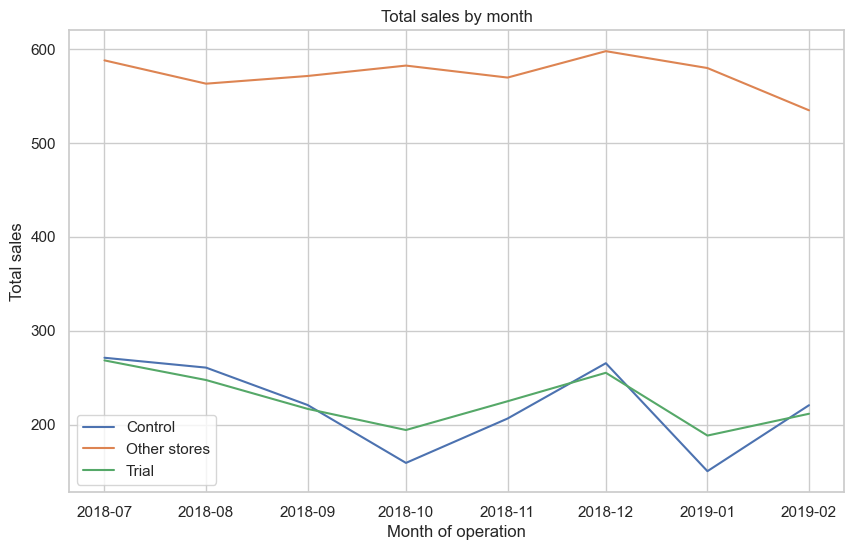

In [9]:
# Calculate average sales per month for different store types
pastSales = measureOverTime.copy()
pastSales.loc[pastSales['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
pastSales.loc[pastSales['STORE_NBR'] == control_store, 'Store_type'] = 'Control'
pastSales['Store_type'].fillna('Other stores', inplace=True)
pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to TransactionMonth
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

# Filter data for months before 2019-03
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Set the style using seaborn
sns.set(style='whitegrid')

# Create the line plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type')

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.savefig("77 Total sales by month.jpg", dpi = 1200)
plt.show()


Next, number of customers.

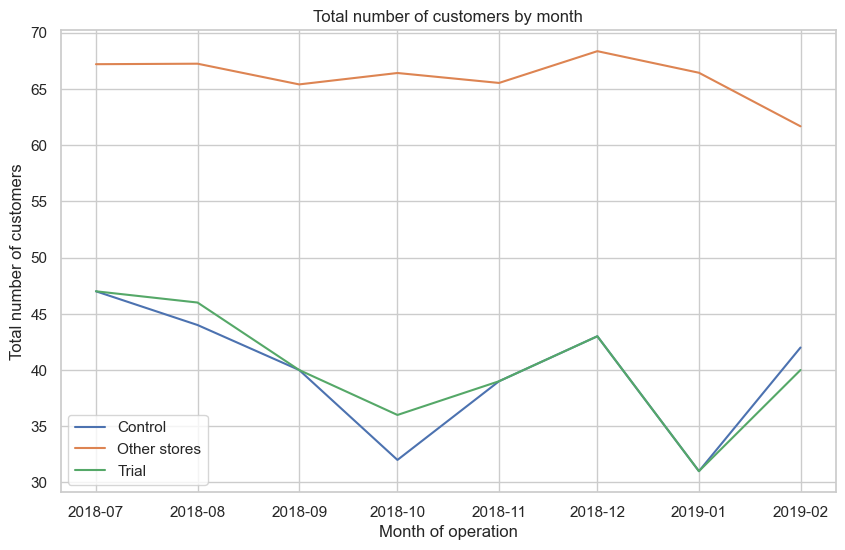

In [10]:
# Calculate average number of customers per month for different store types
pastCustomers = measureOverTime.copy()
pastCustomers['Store_type'] = pastCustomers.apply(lambda row: 'Trial' if row['STORE_NBR'] == trial_store else ('Control' if row['STORE_NBR'] == control_store else 'Other stores'), axis=1)
pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to TransactionMonth
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')

# Filter data for months before 2019-03
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Set the style using seaborn
sns.set(style='whitegrid')

# Create the line plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type')

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.savefig('77 Total number of customers by month.jpg', dpi = 1200)
plt.show()


## Assessment of trial
The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales. <br>
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.


In [11]:
# Calculate scaling factor for control sales
scalingFactorForControlSales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum() / preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
scaledControlSales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == control_store)].copy()
scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales

Now that we have comparable sales figures for the control store, we can calculate the percentage difference
between the scaled control sales and the trial store’s sales during the trial period.

In [12]:
# Merge scaled control sales and trial sales data based on YEARMONTH
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']].merge(
    measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['totSales', 'YEARMONTH']],
    on='YEARMONTH', suffixes=('_control', '_trial')
)

# Calculate percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']


Let’s see if the difference is significant!


In [13]:
from scipy.stats import t

# Calculate the standard deviation for the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Degrees of freedom
degreesOfFreedom = 7

# Calculate t-value
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev

# Convert YEARMONTH to TransactionMonth
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y%m')

# Filter data for months between January 2019 and April 2019
t_values = percentageDiff[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905)][['TransactionMonth', 'tValue']]
t_values

,TransactionMonth,tValue
7,2019-02-01,1.223912
8,2019-03-01,5.633494
9,2019-04-01,11.336505


In [14]:
# Find the 95th percentile of the t distribution with the appropriate
# degrees of freedom to compare against
from scipy import stats

percentile_95 = stats.t.ppf(0.95, df=degreesOfFreedom)

print("95th Percentile:", percentile_95)

95th Percentile: 1.894578605061305


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store. <br>
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
and the 95th percentile value of sales of the control store.

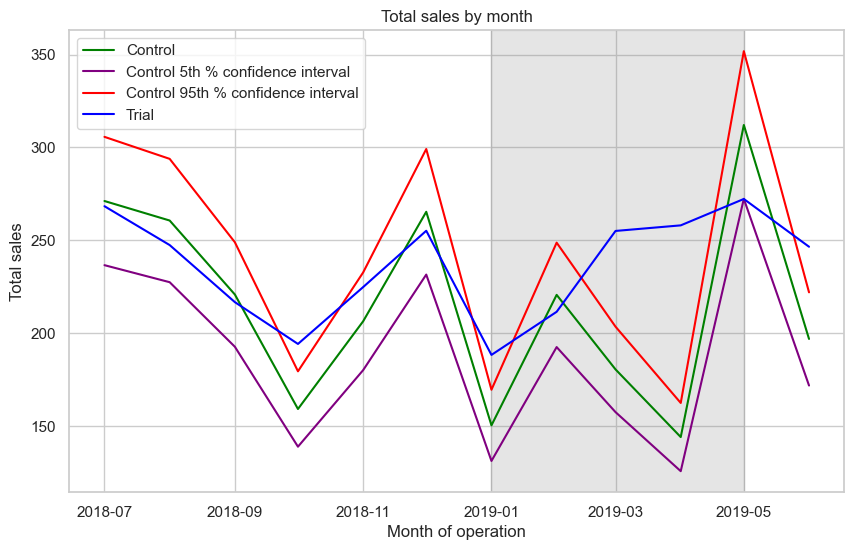

In [15]:
# Create a DataFrame similar to measureOverTimeSales
measureOverTimeSales = measureOverTime.copy()

# Trial and control store total sales

pastSales = measureOverTimeSales.copy()
pastSales['Store_type'] = np.where(pastSales['STORE_NBR'] == trial_store, 'Trial',
                                   np.where(pastSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

pastSales = pastSales[pastSales['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
colors = {'Trial': 'blue', 'Control': 'green', 'Control 95th % confidence interval': 'red',
          'Control 5th % confidence interval': 'purple'}

for store_type, dat in trialAssessment.groupby('Store_type'):
    plt.plot(dat['TransactionMonth'], dat['totSales'], label=store_type, color=colors[store_type])

plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), alpha=0.2, color='gray')
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.savefig('77 Total sales by month interval.jpg', dpi = 1200)
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months. <br>
Let’s have a look at assessing this for number of customers as well.

In [16]:
# Calculate the scaling factor for control customers
scaling_factor_for_control_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                                     (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum() / \
                                  preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                                     (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()

# Create a copy of measureOverTime for customer scaling
measureOverTimeCusts = measureOverTime.copy()

# Scale control store customers
scaledControlCustomers = measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store].copy()
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scaling_factor_for_control_cust
scaledControlCustomers['Store_type'] = 'Control'  # Set store type

# Calculate the percentage difference between scaled control customers and trial customers
percentageDiff = pd.merge(scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
                         measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store][['nCustomers', 'YEARMONTH']],
                         on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']

# Print the resulting DataFrame
percentageDiff


,YEARMONTH,controlCustomers,nCustomers,percentageDiff
0,201807,48.021739,47,0.021277
1,201808,44.956522,46,0.023211
2,201809,40.869565,40,0.021277
3,201810,32.695652,36,0.101064
4,201811,39.847826,39,0.021277
5,201812,43.934783,43,0.021277
6,201901,31.673913,31,0.021277
7,201902,42.913043,40,0.067882
8,201903,35.760870,46,0.286322
9,201904,27.586957,47,0.703704


Let’s again see if the difference is significant visually!


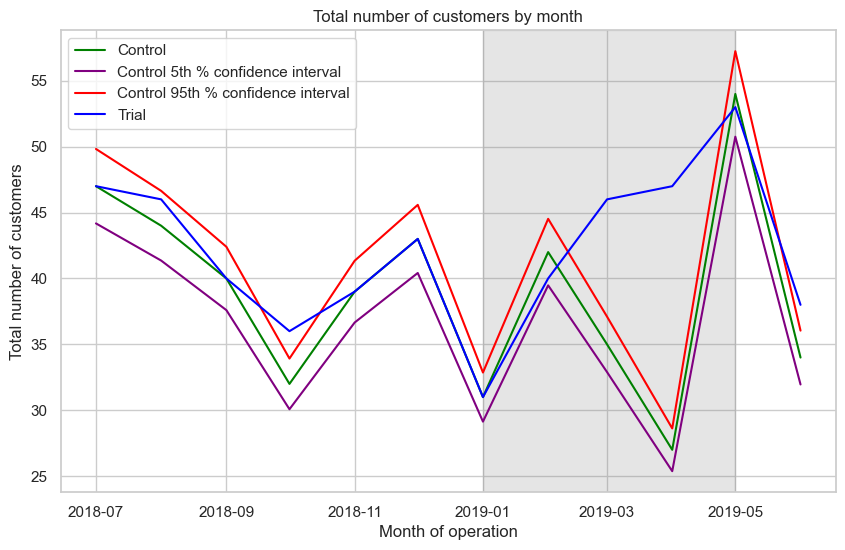

In [17]:
# Calculate the standard deviation based on the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()
degreesOfFreedom = 7

# Trial and control store number of customers
pastCustomers = measureOverTimeCusts.copy()
pastCustomers['Store_type'] = np.where(pastCustomers['STORE_NBR'] == trial_store, 'Trial',
                                       np.where(pastCustomers['STORE_NBR'] == control_store, 'Control', 'Other stores'))
pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['nCustomers'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['nCustomers'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Add 'TransactionMonth' column
trialAssessment['TransactionMonth'] = pd.to_datetime(trialAssessment['YEARMONTH'], format='%Y%m')

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
colors = {'Trial': 'blue', 'Control': 'green', 'Control 95th % confidence interval': 'red',
          'Control 5th % confidence interval': 'purple'}

for store_type, dat in trialAssessment.groupby('Store_type'):
    plt.plot(dat['TransactionMonth'], dat['nCustomers'], label=store_type, color=colors[store_type])

# Highlight the trial period
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), alpha=0.2, color='gray')

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.grid(True)
plt.savefig('77 Total number of customers by month interval.jpg', dpi = 1200)
plt.show()


Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial
stores.

### Trial store 86

In [18]:
# Define the trial_store
trial_store = 86

# Calculate correlation for totSales and nCustomers
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Calculate magnitude distance for totSales and nCustomers
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

corr_weight = 0.5

# Combine correlation and magnitude results for nSales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

# Combine correlation and magnitude results for nCustomers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)

# Combine scores across the drivers for control stores
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Select control store for trial store 86
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False)['Store2'].iloc[1]
control_store

155

Looks like store 155 will be a control store for trial store 86. Again, let’s check visually if the drivers are
indeed similar in the period before the trial.


We’ll look at total sales first

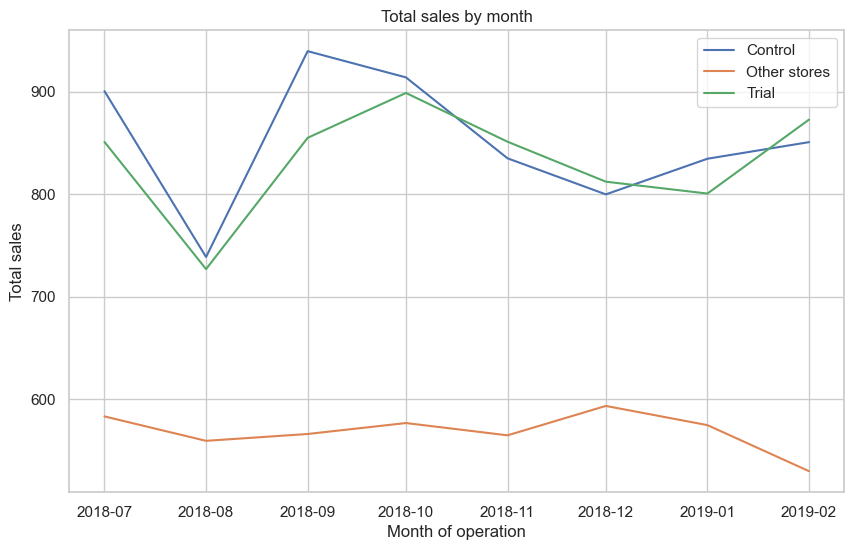

In [19]:
# Calculate average sales per month for different store types
pastSales = measureOverTime.copy()
pastSales.loc[pastSales['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
pastSales.loc[pastSales['STORE_NBR'] == control_store, 'Store_type'] = 'Control'
pastSales['Store_type'].fillna('Other stores', inplace=True)
pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to TransactionMonth
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

# Filter data for months before 2019-03
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Set the style using seaborn
sns.set(style='whitegrid')

# Create the line plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type')

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.savefig('86 Total sales by month.jpg', dpi = 1200)
plt.show()

Great, sales are trending in a similar way

Next, number of customers.

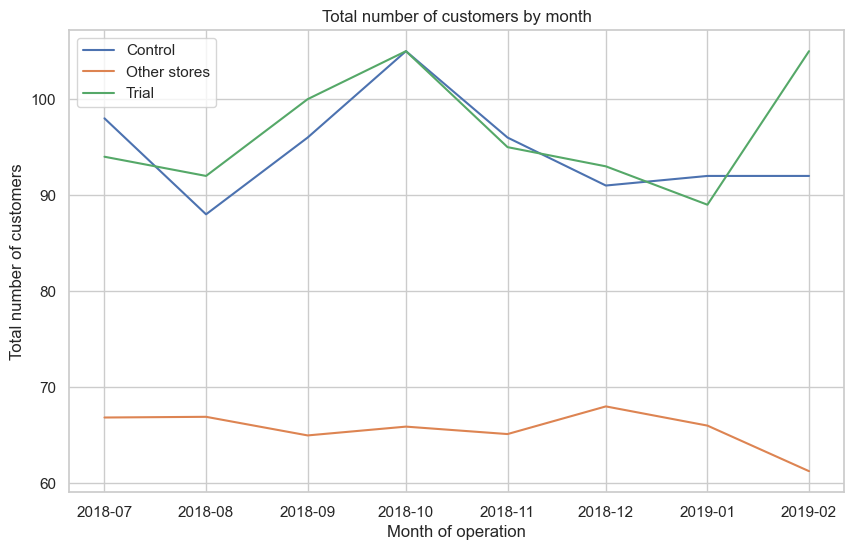

In [20]:
# Calculate average number of customers per month for different store types
pastCustomers = measureOverTime.copy()
pastCustomers['Store_type'] = pastCustomers.apply(lambda row: 'Trial' if row['STORE_NBR'] == trial_store else ('Control' if row['STORE_NBR'] == control_store else 'Other stores'), axis=1)
pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to TransactionMonth
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')

# Filter data for months before 2019-03
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Set the style using seaborn
sns.set(style='whitegrid')

# Create the line plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type')

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.savefig('86 Total number of customers by month.jpg', dpi = 1200)
plt.show()


Good, the trend in number of customers is also similar.

Let’s now assess the impact of the trial on sales.

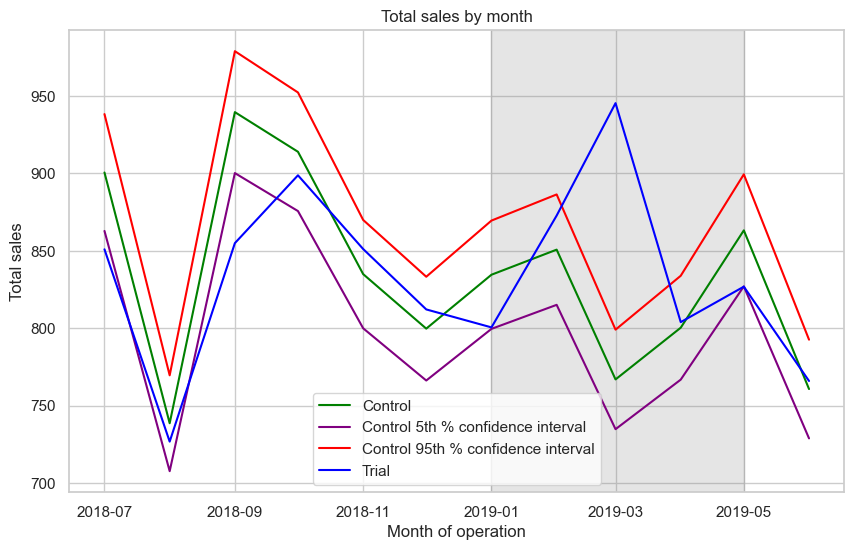

In [21]:
# Calculate scaling factor for control sales
scalingFactorForControlSales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum() / preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
scaledControlSales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == control_store)].copy()
scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales

# Merge scaled control sales and trial sales data based on YEARMONTH
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']].merge(
    measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['totSales', 'YEARMONTH']],
    on='YEARMONTH', suffixes=('_control', '_trial')
)

# Calculate percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']

# Calculate the standard deviation for the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Degrees of freedom
degreesOfFreedom = 7

# Trial and control store total sales

pastSales = measureOverTimeSales.copy()
pastSales['Store_type'] = np.where(pastSales['STORE_NBR'] == trial_store, 'Trial',
                                   np.where(pastSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

pastSales = pastSales[pastSales['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
colors = {'Trial': 'blue', 'Control': 'green', 'Control 95th % confidence interval': 'red',
          'Control 5th % confidence interval': 'purple'}

for store_type, dat in trialAssessment.groupby('Store_type'):
    plt.plot(dat['TransactionMonth'], dat['totSales'], label=store_type, color=colors[store_type])

plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), alpha=0.2, color='gray')
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.savefig('86 Total sales by month interval.jpg', dpi = 1200)
plt.show()

The results show that the trial in store 86 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.


Let’s have a look at assessing this for number of customers as well.

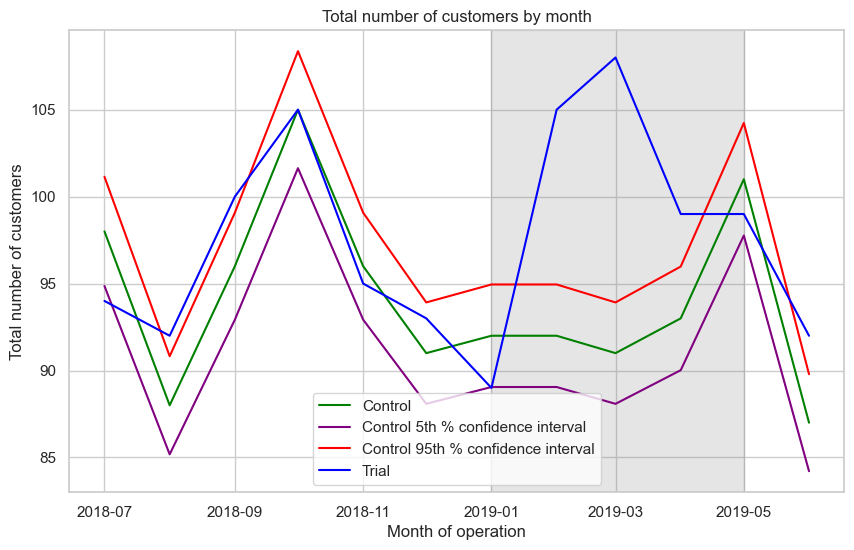

In [22]:
# Calculate the scaling factor for control customers
scaling_factor_for_control_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                                     (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum() / \
                                  preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                                     (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()

# Create a copy of measureOverTime for customer scaling
measureOverTimeCusts = measureOverTime.copy()

# Scale control store customers
scaledControlCustomers = measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store].copy()
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scaling_factor_for_control_cust

# Calculate the percentage difference between scaled control customers and trial customers
percentageDiff = pd.merge(scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
                         measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store][['nCustomers', 'YEARMONTH']],
                         on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']
# Calculate the standard deviation based on the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()
degreesOfFreedom = 7

# Trial and control store number of customers
pastCustomers = measureOverTimeCusts.copy()
pastCustomers['Store_type'] = np.where(pastCustomers['STORE_NBR'] == trial_store, 'Trial',
                                       np.where(pastCustomers['STORE_NBR'] == control_store, 'Control', 'Other stores'))
pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['nCustomers'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['nCustomers'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Add 'TransactionMonth' column
trialAssessment['TransactionMonth'] = pd.to_datetime(trialAssessment['YEARMONTH'], format='%Y%m')

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
colors = {'Trial': 'blue', 'Control': 'green', 'Control 95th % confidence interval': 'red',
          'Control 5th % confidence interval': 'purple'}

for store_type, dat in trialAssessment.groupby('Store_type'):
    plt.plot(dat['TransactionMonth'], dat['nCustomers'], label=store_type, color=colors[store_type])

# Highlight the trial period
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), alpha=0.2, color='gray')

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.grid(True)
plt.savefig('86 Total number of customers by month interval.jpg', dpi = 1200)
plt.show()


It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.


### Trial store 88


In [23]:
# Define the trial_store
trial_store = 88

# Calculate correlation for totSales and nCustomers
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Calculate magnitude distance for totSales and nCustomers
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

corr_weight = 0.5

# Combine correlation and magnitude results for nSales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

# Combine correlation and magnitude results for nCustomers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)

# Combine scores across the drivers for control stores
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Select control store for trial store 86
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False)['Store2'].iloc[1]
control_store

237

We’ve now found store 237 to be a suitable control store for trial store 88. <br>
<br>
Again, let’s check visually if the drivers are indeed similar in the period before the trial.<br>
<br>
We’ll look at total sales first.<br>


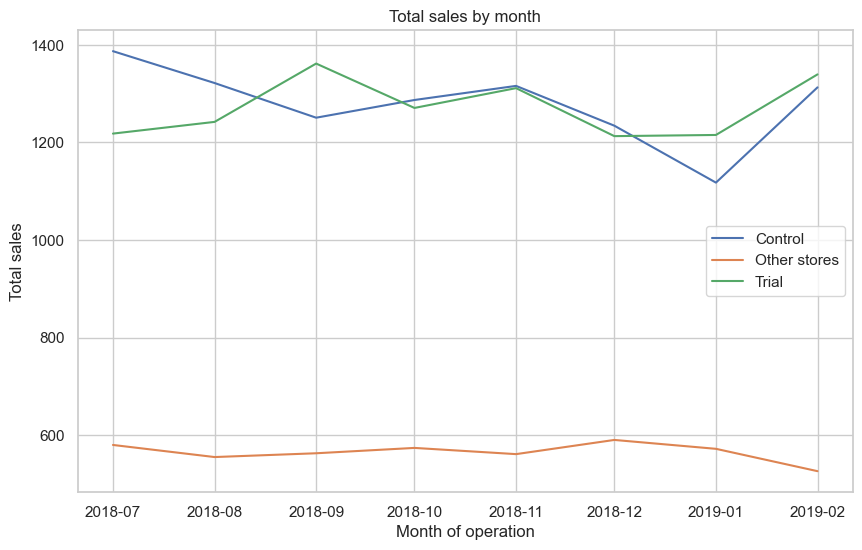

In [24]:
# Calculate average sales per month for different store types
pastSales = measureOverTime.copy()
pastSales.loc[pastSales['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
pastSales.loc[pastSales['STORE_NBR'] == control_store, 'Store_type'] = 'Control'
pastSales['Store_type'].fillna('Other stores', inplace=True)
pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to TransactionMonth
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

# Filter data for months before 2019-03
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Set the style using seaborn
sns.set(style='whitegrid')

# Create the line plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type')

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.savefig('88 Total sales by month.jpg', dpi = 1200)
plt.show()

Great, the trial and control stores have similar total sales.<br>
<br>
Next, number of customers.

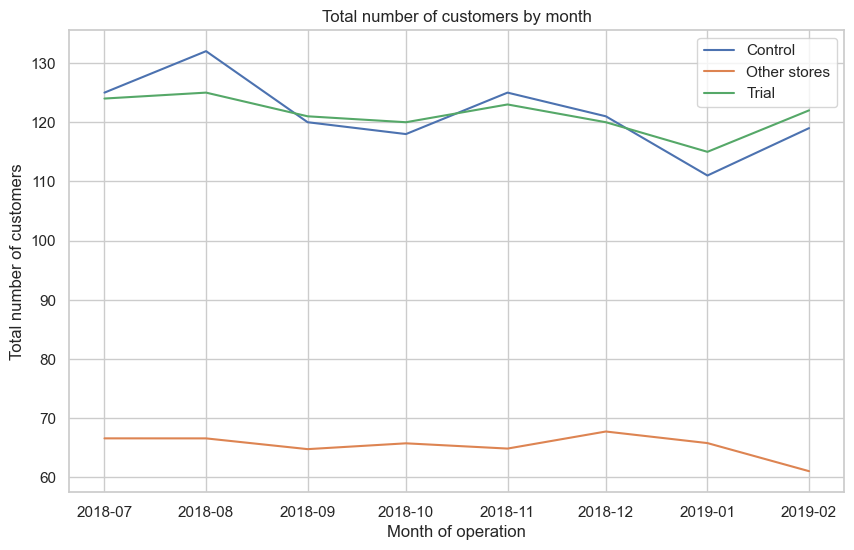

In [25]:
# Calculate average number of customers per month for different store types
pastCustomers = measureOverTime.copy()
pastCustomers['Store_type'] = pastCustomers.apply(lambda row: 'Trial' if row['STORE_NBR'] == trial_store else ('Control' if row['STORE_NBR'] == control_store else 'Other stores'), axis=1)
pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to TransactionMonth
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')

# Filter data for months before 2019-03
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Set the style using seaborn
sns.set(style='whitegrid')

# Create the line plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type')

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.savefig('88 Total number of customers by month.jpg', dpi = 1200)
plt.show()


Total number of customers of the control and trial stores are also similar.<br>
<br>
Let’s now assess the impact of the trial on sales.


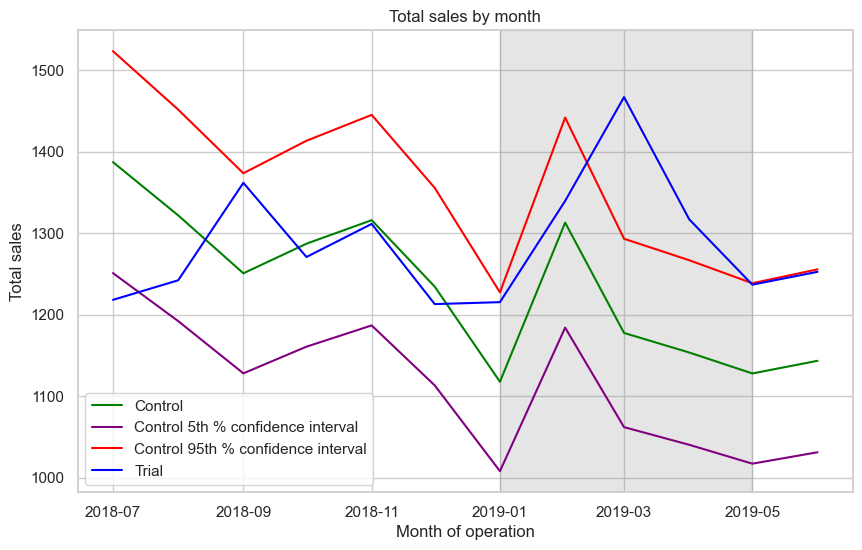

In [26]:
# Calculate scaling factor for control sales
scalingFactorForControlSales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum() / preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
scaledControlSales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == control_store)].copy()
scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales

# Merge scaled control sales and trial sales data based on YEARMONTH
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']].merge(
    measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['totSales', 'YEARMONTH']],
    on='YEARMONTH', suffixes=('_control', '_trial')
)

# Calculate percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']

# Calculate the standard deviation for the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Degrees of freedom
degreesOfFreedom = 7

# Trial and control store total sales

pastSales = measureOverTimeSales.copy()
pastSales['Store_type'] = np.where(pastSales['STORE_NBR'] == trial_store, 'Trial',
                                   np.where(pastSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

pastSales = pastSales[pastSales['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
colors = {'Trial': 'blue', 'Control': 'green', 'Control 95th % confidence interval': 'red',
          'Control 5th % confidence interval': 'purple'}

for store_type, dat in trialAssessment.groupby('Store_type'):
    plt.plot(dat['TransactionMonth'], dat['totSales'], label=store_type, color=colors[store_type])

plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), alpha=0.2, color='gray')
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.savefig('88 Total sales by month interval.jpg', dpi = 1200)
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as the
trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the
three trial months.<br>
<br>
Let’s have a look at assessing this for number of customers as well.

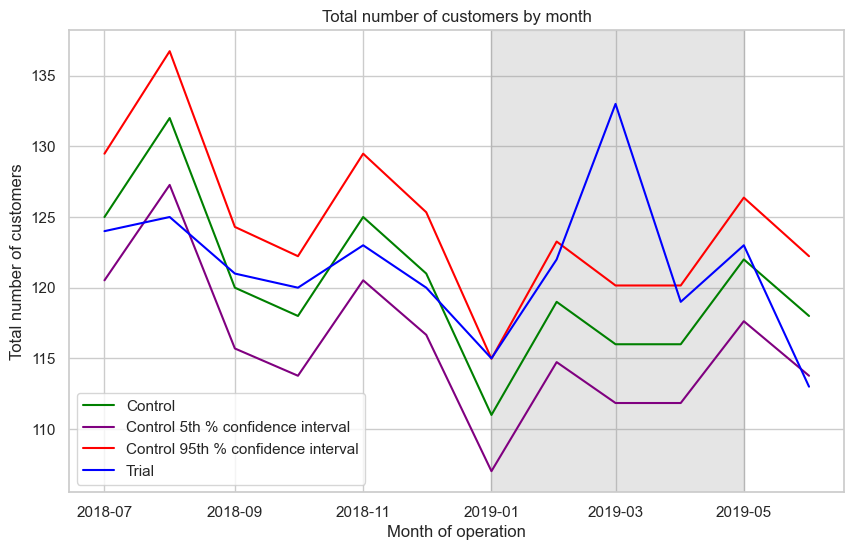

In [27]:
# Calculate the scaling factor for control customers
scaling_factor_for_control_cust = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                                     (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum() / \
                                  preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                                     (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()

# Create a copy of measureOverTime for customer scaling
measureOverTimeCusts = measureOverTime.copy()

# Scale control store customers
scaledControlCustomers = measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store].copy()
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scaling_factor_for_control_cust

# Calculate the percentage difference between scaled control customers and trial customers
percentageDiff = pd.merge(scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
                         measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store][['nCustomers', 'YEARMONTH']],
                         on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']
# Calculate the standard deviation based on the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()
degreesOfFreedom = 7

# Trial and control store number of customers
pastCustomers = measureOverTimeCusts.copy()
pastCustomers['Store_type'] = np.where(pastCustomers['STORE_NBR'] == trial_store, 'Trial',
                                       np.where(pastCustomers['STORE_NBR'] == control_store, 'Control', 'Other stores'))
pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['nCustomers'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['nCustomers'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Add 'TransactionMonth' column
trialAssessment['TransactionMonth'] = pd.to_datetime(trialAssessment['YEARMONTH'], format='%Y%m')

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
colors = {'Trial': 'blue', 'Control': 'green', 'Control 95th % confidence interval': 'red',
          'Control 5th % confidence interval': 'purple'}

for store_type, dat in trialAssessment.groupby('Store_type'):
    plt.plot(dat['TransactionMonth'], dat['nCustomers'], label=store_type, color=colors[store_type])

# Highlight the trial period
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), alpha=0.2, color='gray')

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.grid(True)
plt.savefig('88 Total number of customers by month interval.jpg', dpi = 1200)
plt.show()


Total number of customers in the trial period for the trial store is significantly higher than the control store
for two out of three months, which indicates a positive trial effect.

## Conclusion

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.<br>
<br>
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86. We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that
we have finished our analysis, we can prepare our presentation to the Category Manager.